## Importing Libraries

In [5]:
# Python basic Ml libraries
import numpy as np # Numerical processing
import pandas as pd

# Data visualization 
import matplotlib.pyplot as plt # For visulization 

#ML frameworks
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline


# DL frameworks
import torch # Tensor computation
import torch.nn as nn # Neural Networks
import torch.optim as optim # Neural Nework optimizers
import torchtext # Text processing
import tqdm # For measuing progress
from torch.utils.data import Dataset, DataLoader


# Required additional libaries
import os
import gzip
import json
import requests
import collections



/Users/saugatmalla/Documents/Projects/LazyReader/py/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/saugatmalla/Documents/Projects/LazyReader/py/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Downloading dataset

In [6]:
DIR = './'

In [7]:
fileNames = pd.read_csv(os.path.join(DIR,"dataset_names.csv"))
display(fileNames)                       

,type,name
0,complete,goodreads_book_works.json.gz
1,complete,goodreads_book_authors.json.gz
2,complete,goodreads_book_series.json.gz
3,complete,goodreads_books.json.gz
4,complete,goodreads_book_genres_initial.json.gz
5,byGenre,goodreads_books_children.json.gz
6,byGenre,goodreads_books_comics_graphic.json.gz
7,byGenre,goodreads_books_fantasy_paranormal.json.gz
8,byGenre,goodreads_books_history_biography.json.gz
9,byGenre,goodreads_books_mystery_thriller_crime.json.gz


In [8]:
# Constructing url for donwloading the dataset
fileName_type_mapping = dict(zip(fileNames['name'].values, fileNames['type'].values))
fileName_url_mapping = {}

for fName in fileName_type_mapping:
    ftype = fileName_type_mapping[fName]
    if ftype == "complete":
        url = 'https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/goodreads/'+fName
        fileName_url_mapping[fName] = url
    elif ftype == "byGenre":
        url = 'https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/goodreads/byGenre/'+fName
        fileName_url_mapping[fName] = url

In [9]:
def download_byName(fname, local_fileName):
    if fname in fileName_url_mapping:
        url = fileName_url_mapping[fname]

        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            
            with open(local_fileName, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
        print("Dataset ", fname, " has been downloaded")
    else:
        print("Dataset ", fname, " cannot be found")

In [10]:
## Downloading the dataset without GUI
# outDir = './customerReviews'

# if not os.path.exists(outDir):
#     os.makedirs(outDir)
    
# output_path = os.path.join(outDir, 'goodreads_reviews_dedup.json.gz')
# download_byName('goodreads_reviews_dedup.json.gz', output_path)


In [11]:
# device = (
#     "cuda"
#     if torch.cuda.is_available()
#     else "mps"
#     if torch.backends.mps.is_available()
#     else "cpu"
# )

In [12]:
# device = 'cpu'

## Importing Data

In [13]:
import dask.dataframe as dd

datasetPath = './customerReviews/goodreads_reviews_dedup.json.gz'

chunk_size = 10000  # Adjust the chunk size based on your system's memory capacity

# With pandas
chunks = pd.read_json(datasetPath, lines=True, compression='gzip', chunksize=chunk_size, nrows=100000)
# Read JSON data with Dask
#ddf = dd.read_json(datasetPath, lines=True, compression='gzip').head(1000)

# Generator expression to read random rows (200000 in this case) from each chunk
sampled_chunks = (chunk.sample(n=10000, random_state=42) for chunk in chunks)
# Sample the dataframe with dask
#sampled_ddf = ddf.sample(frac=0.001, random_state=42).head(1)  # Adjust the fraction as needed


# # Concatenate teh sampled chunks into a dataframe
df = pd.concat(sampled_chunks, ignore_index=True)
# Compute the Dask dataframe to obtain a Pandas dataframe
#df = sampled_ddf.compute()

In [14]:
df

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,d4b1dcb35db677f20ee45225a5e43be2,93436,d48b5afd9f57e588ac3c91dfe7fa859b,5,Amazing. I cannot believe it took me this long...,Sun Aug 05 15:22:23 -0700 2007,Thu Dec 17 03:51:57 -0800 2009,Sat Sep 01 00:00:00 -0700 2007,,0,0
1,cd6522e9018f2f77332ec74f928f8c45,266765,0b9d92d61f295fcb08fd1e14761f52d4,3,"Ihan hyva omassa kategoriassaan, mutta pakosti...",Sat Jul 28 02:33:08 -0700 2012,Sat Jul 28 02:35:03 -0700 2012,Wed Sep 13 00:00:00 -0700 2006,,0,0
2,0ef32090550901ead25cb0ea21c4d36b,35282714,9d12eb66d95d1c20eb8d2db1e1ee40b2,3,This is a solid follow up to The Girl on the T...,Tue Jun 20 07:48:07 -0700 2017,Tue Jun 20 07:56:12 -0700 2017,Mon Jun 19 00:00:00 -0700 2017,Fri Jun 02 00:00:00 -0700 2017,1,0
3,cd6522e9018f2f77332ec74f928f8c45,3049635,cdfb7a66f16f65a3f2fdf9d826c9c516,3,"Muutama sana koko sarjasta. Sarja alkaa hyvin,...",Thu Jul 26 11:54:22 -0700 2012,Thu Jul 26 11:58:33 -0700 2012,Wed Apr 26 00:00:00 -0700 2006,,0,0
4,cd6522e9018f2f77332ec74f928f8c45,5560595,9eefa83d1150440cb240f3ec78ee9e78,2,"Uusin Marklund, joka on tuttuun tapaan helppo ...",Thu Aug 16 08:26:00 -0700 2012,Thu Aug 16 08:30:54 -0700 2012,Wed Nov 05 00:00:00 -0800 2008,,0,0
...,...,...,...,...,...,...,...,...,...,...,...
99995,edc68f0f9e163d47b1503b3cdc4e2c5e,25667918,035fc283d2c09b015037ff5f5897d59d,4,This was so ferocious/heart-warming! \n Fangir...,Mon Jun 08 14:24:35 -0700 2015,Tue Dec 20 21:57:47 -0800 2016,,,7,0
99996,a6d2293f4d6542e2edb335eab2daad39,1857440,07aeb7de221c8f16656fb46f072c38bb,5,"A highly entertaining, occasionally hilarious,...",Sun Jul 07 21:26:13 -0700 2013,Sun Jul 07 21:29:09 -0700 2013,Sun Jul 07 00:00:00 -0700 2013,,0,0
99997,a6d2293f4d6542e2edb335eab2daad39,220926,8ae4e5ec0cb9b49a2b8b0e6eaefb707c,3,The ideas in this book are as dense as the wor...,Sun May 27 22:48:25 -0700 2007,Sat Jul 14 06:21:38 -0700 2007,Sun Jul 01 00:00:00 -0700 2007,,0,4
99998,37b3e60b4e4152c580fd798d405150ff,5067355,d5f621f9f89aeb6e4c1f38d1671a9860,4,Great characters & a story that continues to b...,Sat Aug 25 14:30:28 -0700 2012,Sat Aug 25 14:30:47 -0700 2012,Wed Dec 17 00:00:00 -0800 2008,,0,0


In [15]:
def count_reviews(file_name):
    print('counting file:', file_name)
    n_review = 0
    book_set, user_set = set(), set()
    print('current line: ', end='')
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            if n_review % 1000000 == 0:
                print(n_review, end=',')
            n_review += 1
            book_set.add(d['book_id'])
            user_set.add(d['user_id'])
    print('complete')
    print('done!')
    return n_review, len(book_set), len(user_set)

In [16]:
DIR = './customerReviews'
n_review, n_book, n_user = count_reviews(os.path.join(DIR, 'goodreads_reviews_dedup.json.gz'))
df_stats_review = pd.DataFrame([n_review, n_book, n_user], dtype=float,
                               columns=['count'], index=['# review', '# book', '# user'])
display(df_stats_review)

counting file: ./customerReviews/goodreads_reviews_dedup.json.gz
current line: 0,1000000,2000000,3000000,4000000,5000000,6000000,7000000,8000000,9000000,10000000,11000000,12000000,13000000,14000000,15000000,complete
done!


,count
# review,15739967.0
# book,2080190.0
# user,465323.0


In [17]:
df_stats_review.head()

,count
# review,15739967.0
# book,2080190.0
# user,465323.0


## Data preprocessing

### Feature selection

In [18]:
selected_features = ['book_id', 'rating', 'review_text']

x_data = df[selected_features]

In [19]:
x_data

,book_id,rating,review_text
0,93436,5,Amazing. I cannot believe it took me this long...
1,266765,3,"Ihan hyva omassa kategoriassaan, mutta pakosti..."
2,35282714,3,This is a solid follow up to The Girl on the T...
3,3049635,3,"Muutama sana koko sarjasta. Sarja alkaa hyvin,..."
4,5560595,2,"Uusin Marklund, joka on tuttuun tapaan helppo ..."
...,...,...,...
99995,25667918,4,This was so ferocious/heart-warming! \n Fangir...
99996,1857440,5,"A highly entertaining, occasionally hilarious,..."
99997,220926,3,The ideas in this book are as dense as the wor...
99998,5067355,4,Great characters & a story that continues to b...


In [20]:
# Setting random seeds to ensure that result is reproducable nad we get the same results everytime the notebook is run.
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

### Creating custom dataset

In [21]:
# # Another way:
# class CustomDataset(Dataset):
#     def __init__(self, dataframe, transform=None):
#         self.dataframe = dataframe
#         self.transform = transform

#     def __len__(self):
#         return len(self.dataframe)

#     def __getitem__(self, idx):
#         sample = self.dataframe.iloc[idx].to_dict()

#         # Apply any preprocessing or transformations if needed
#         if self.transform:
#             sample['review_text'] = self.transform(sample['review_text'])

#         return sample

# # Preprocessing for text data using scikit learn
# text_pipeline = Pipeline([
#     ('vect', CountVectorizer()),
#     ('tfidf', TfidfTransformer())
# ])


# # Create instances of the dataset
# train_dataset = CustomDataset(train_data, transform=text_pipeline)
# val_dataset = CustomDataset(val_data, transform=text_pipeline)
# test_dataset = CustomDataset(test_data, transform=text_pipeline)

# # Create PyTorch DataLoaders
# train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
# test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## For Getting labels 
#### 0-2: Negative
#### 3: Neutral
#### 4-5: Positive

In [22]:
# Split the data into training, validation sets and test sets
train_data, temp_data = train_test_split(x_data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)


In [23]:
train_data['review_text'][1]

'Ihan hyva omassa kategoriassaan, mutta pakosti tuli verrattua Louise Rennisonin Georgia Nicholson-kirjoihin, jotka ovat tyyliltaan hyvin samankaltaisia, mutta parempia. Ei tamakaan huono ollut, mutta Georgiat ovat parempia.'

In [24]:
# Creating a dictionary with review and its book_id
train_data_br = []
test_data_br = []
valid_data_br = []

# for r_data, b_data in zip(train_data['review_text'],train_data['book_id']):
#     #print(train_data[data])
#     train_data_br.append({'review':r_data, 'book_id':b_data})

# for r_data, b_data in zip(test_data['review_text'],test_data['book_id']):
#     test_data_br.append({'review':r_data, 'book_id':b_data})

# for r_data, b_data in zip(val_data['review_text'],val_data['book_id']):
#     valid_data_br.append({'review':r_data, 'book_id':b_data})

for r_data, ra_data in zip(train_data['review_text'],train_data['rating']):
    #print(train_data[data])
    if(ra_data>3):
        label = 1
    else:
        label = 0
    
    train_data_br.append({'review':r_data, 'rating':label})

for r_data, ra_data in zip(test_data['review_text'],test_data['rating']):
    if(ra_data>3):
        label = 1
    else:
        label = 0
    
    test_data_br.append({'review':r_data, 'rating':label})

for r_data, ra_data in zip(val_data['review_text'],val_data['rating']):
    if(ra_data>3):
        label = 1
    else:
        label = 0
    
    valid_data_br.append({'review':r_data, 'rating':label})

In [25]:
train_data_br[0]

{'review': "Quick read, interesting background stories. Not sure I think even Graff is that crafty, plus you'd think JP would recognize someone who played such a major role in his life...",
 'rating': 1}

In [26]:
train_data_br[0]['review']

"Quick read, interesting background stories. Not sure I think even Graff is that crafty, plus you'd think JP would recognize someone who played such a major role in his life..."

In [27]:
len(train_data_br)

80000

## Tokenization

In [28]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

In [29]:
tokenizer("Goodreads book reviews sentiment analysis")

['goodreads', 'book', 'reviews', 'sentiment', 'analysis']

In [30]:
# Tokenize the data after creating the dataset and dataloader

# def tokenize_dataset(dataset, tokenizer, max_len):
#     def tokenize_example(example):
#         # Tokenize the review text using the tokenizer
#         tokenized_inputs = tokenizer(
#             example['review_text']
#         )

#         # Include other features if needed
#         #tokenized_inputs['book_id'] = example['book_id']
#         #tokenized_input['rating'] = example['rating']

#         return tokenized_inputs
#     return dataset.dataframe.apply(tokenize_example, axis=1)

def tokenize_example(example, tokenizer, max_length):
        # Tokenize the review text using the tokenizer
        tokens = tokenizer(example["review"])[:max_length]

        # Include other features if needed
        #tokenized_inputs['book_id'] = example['book_id']
        #tokenized_input['rating'] = example['rating']

        #return {"tokens":tokens}
        return tokens

In [31]:
# max_length = 256

# # Tokenize the datasets
# tokenized_train_data = tokenize_dataset(train_dataset, tokenizer, max_length)
# tokenized_test_data = tokenize_dataset(test_dataset, tokenizer, max_length)

# # Update the datasets with tokenized data
# train_dataset.dataframe = tokenized_train_data
# test_dataset.dataframe = tokenized_test_data

# Updating the dataloaders as well
# train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [32]:
max_length = 256

for index in range(len(train_data_br)):
    tokens = tokenize_example(train_data_br[index], tokenizer, max_length)
    
    train_data_br[index]["tokens"] = tokens

for index in range(len(test_data_br)):
    tokens = tokenize_example(test_data_br[index], tokenizer, max_length)
    
    test_data_br[index]["tokens"] = tokens

for index in range(len(valid_data_br)):
    tokens = tokenize_example(valid_data_br[index], tokenizer, max_length)
    
    valid_data_br[index]["tokens"] = tokens

In [33]:
train_data_br[0]['review']

"Quick read, interesting background stories. Not sure I think even Graff is that crafty, plus you'd think JP would recognize someone who played such a major role in his life..."

In [34]:
train_data_br[0]

{'review': "Quick read, interesting background stories. Not sure I think even Graff is that crafty, plus you'd think JP would recognize someone who played such a major role in his life...",
 'rating': 1,
 'tokens': ['quick',
  'read',
  ',',
  'interesting',
  'background',
  'stories',
  '.',
  'not',
  'sure',
  'i',
  'think',
  'even',
  'graff',
  'is',
  'that',
  'crafty',
  ',',
  'plus',
  'you',
  "'",
  'd',
  'think',
  'jp',
  'would',
  'recognize',
  'someone',
  'who',
  'played',
  'such',
  'a',
  'major',
  'role',
  'in',
  'his',
  'life',
  '.',
  '.',
  '.']}

In [35]:
train_data_br[0]["tokens"]

['quick',
 'read',
 ',',
 'interesting',
 'background',
 'stories',
 '.',
 'not',
 'sure',
 'i',
 'think',
 'even',
 'graff',
 'is',
 'that',
 'crafty',
 ',',
 'plus',
 'you',
 "'",
 'd',
 'think',
 'jp',
 'would',
 'recognize',
 'someone',
 'who',
 'played',
 'such',
 'a',
 'major',
 'role',
 'in',
 'his',
 'life',
 '.',
 '.',
 '.']

In [36]:
train_data_br[0]["tokens"][:25]

['quick',
 'read',
 ',',
 'interesting',
 'background',
 'stories',
 '.',
 'not',
 'sure',
 'i',
 'think',
 'even',
 'graff',
 'is',
 'that',
 'crafty',
 ',',
 'plus',
 'you',
 "'",
 'd',
 'think',
 'jp',
 'would',
 'recognize']

In [37]:
len(train_data_br), len(test_data_br), len(valid_data_br)

(80000, 10000, 10000)

## Creating Vocabulary

In [38]:
min_freq = 5

special_tokens = ["<unk>", "<pad>"]

vocab = torchtext.vocab.build_vocab_from_iterator(
    [train_data_br[index]['tokens'] for index in range(len(train_data_br))],
    min_freq=min_freq, 
    specials=special_tokens,
)

In [39]:
len(vocab)

37969

In [40]:
# Viewing the tokens in the vocabulary
vocab.get_itos()[:10]

['<unk>', '<pad>', '.', 'the', ',', 'and', 'i', 'a', 'to', "'"]

In [41]:
vocab["and"]

5

In [42]:
# Storing the index of unknown and padding special tokens
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]

In [43]:
# Cheking if token in vocab
"awesome" in vocab

True

In [44]:
# To overwrite the default error taht we get with torchtext when token not in vocab

vocab.set_default_index(unk_index)

In [45]:
vocab['bike pencil']

0

In [46]:
# To look at the list of tokens
vocab.lookup_indices(["hello", "world", "bike pencil", "<pad>"])

[5644, 121, 0, 1]

## Numericalizing Data

In [47]:
# To get ids of tokens from that example
def numericalize_example(example, vocab):
    ids = vocab.lookup_indices(example["tokens"])
    #return {"ids": ids}
    return ids

In [48]:
max_length = 256

for index in range(len(train_data_br)):
    ids = numericalize_example(train_data_br[index], vocab)
    
    train_data_br[index]["ids"] = ids

for index in range(len(test_data_br)):
    ids = numericalize_example(test_data_br[index], vocab)
    
    test_data_br[index]["ids"] = ids

for index in range(len(valid_data_br)):
    ids = numericalize_example(valid_data_br[index], vocab)
    
    valid_data_br[index]["ids"] = ids

In [49]:
train_data_br[0]["tokens"][:10]

['quick',
 'read',
 ',',
 'interesting',
 'background',
 'stories',
 '.',
 'not',
 'sure',
 'i']

In [50]:
# Ids of token from that example
vocab.lookup_indices(train_data_br[0]["tokens"][:10])

[371, 26, 4, 122, 805, 156, 2, 28, 201, 6]

In [51]:
train_data_br[0]["ids"][:10]

[371, 26, 4, 122, 805, 156, 2, 28, 201, 6]

In [52]:
## Converting ids and labels from integers into Pytorch tensors
#train_data_br = train_data_br.with_format(type="torch", columns=['ids', 'label'])

for i in range(len(train_data_br)):
    
    # Convert ids and book_ids to PyTorch tensor
    train_data_br[i]['ids'] = torch.tensor(train_data_br[i]['ids'])
    train_data_br[i]['rating'] = torch.tensor(train_data_br[i]['rating'])

    # Replace the existing 'ids' and 'book_id' values with PyTorch tensors
    # train_data_br[i]['ids'] = ids_tensor.tolist() # If need to convert tensor back to lost
    # train_data_br[i]['book_id'] = bookids_tensor.item()  # Convert tensor back to scalar

for i in range(len(test_data_br)):
    
    # Convert ids and labels to PyTorch tensor
    test_data_br[i]['ids'] = torch.tensor(test_data_br[i]['ids'])
    test_data_br[i]['rating'] = torch.tensor(test_data_br[i]['rating'])

for i in range(len(valid_data_br)):
    
    # Convert ids and labels to PyTorch tensor
    valid_data_br[i]['ids'] = torch.tensor(valid_data_br[i]['ids'])
    valid_data_br[i]['rating'] = torch.tensor(valid_data_br[i]['rating'])

In [53]:
train_data_br[1]['rating']

tensor(1)

In [54]:
train_data_br[0]["ids"][:10]

tensor([371,  26,   4, 122, 805, 156,   2,  28, 201,   6])

In [55]:
# To get the human redable token back
vocab.lookup_tokens(train_data_br[0]["ids"][:10].tolist())

['quick',
 'read',
 ',',
 'interesting',
 'background',
 'stories',
 '.',
 'not',
 'sure',
 'i']

## Creating Data Loaders

In [56]:
# Function to collate a batch
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_rating = [i["rating"] for i in batch]
        batch_rating = torch.stack(batch_rating)
        batch = {"ids": batch_ids, "rating": batch_rating}

        return batch
    return collate_fn

In [57]:
# Function that returns actuial data loader.
# batch size: (number of sentences in the batch), padding token index, shuffle dataset

def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset, 
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle
    )
    return data_loader

In [58]:
# Getting the data loader
batch_size = 512

train_data_loader = get_data_loader(train_data_br, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data_br, batch_size, pad_index)
test_data_loader = get_data_loader(test_data_br, batch_size, pad_index)

In [59]:
train_data_loader

## Building the model

### Neural Bag of Words

In [60]:
class NBoW(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, ids):
        # ids = [batch size, seq len]
        #embedded = self.embedding(ids)
        embedded = self.embedding(ids.to(torch.long))
        # embedded = [batch size, seq len, embedding dim]
        pooled = embedded.mean(dim=1)
        # pooled = [batch size, embeddiong dim]
        prediction = self.fc(pooled)
        # prediction = [batch size, output dim]
        return prediction        


In [61]:
train_data_br[1]['rating'].tolist()

1

In [62]:
# def unique(feature):
#     uniqueList = []
    
#     for x in range(len(train_data_br)):
#         if(train_data_br[x]['book_id'].tolist() not in uniqueList):
#             uniqueList.append(train_data_br[x]['book_id'])
#     return uniqueList

def unique(feature):
    
    # uniqueList = {}
    # for x in range(len(train_data_br)):
    #     if(train_data_br[x]['rating'].tolist() not in uniqueList):
    #         uniqueList[train_data_br[x]['rating']] = 1
    uniqueList = []
    for x in range(len(train_data_br)):
        if(train_data_br[x]['rating'].tolist() not in uniqueList):
            uniqueList.append(train_data_br[x]['rating'])
    return uniqueList


# We could have just counted the tensors as well

In [63]:
vocab_size = len(vocab)
embedding_dim = 300
output_dim = len(unique("rating"))
#output_dim = 2

model = NBoW(vocab_size, embedding_dim, output_dim, pad_index)

In [64]:
print(output_dim)

2


In [65]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 11,391,302 trainable parameters


In [66]:
vectors = torchtext.vocab.GloVe()

In [67]:
hello_vector = vectors.get_vecs_by_tokens("hello")

In [68]:
hello_vector.shape

torch.Size([300])

In [69]:
hello_vector[:32]

tensor([ 0.2523,  0.1018, -0.6748,  0.2112,  0.4349,  0.1654,  0.4826, -0.8122,
         0.0413,  0.7850, -0.0779, -0.6632,  0.1464, -0.2929, -0.2549,  0.0193,
        -0.2026,  0.9823,  0.0283, -0.0813, -0.1214,  0.1313, -0.1765,  0.1356,
        -0.1636, -0.2257,  0.0550, -0.2031,  0.2072,  0.0958,  0.2248,  0.2154])

In [70]:
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())
pretrained_embedding.shape

torch.Size([37969, 300])

In [71]:
model.embedding.weight

Parameter containing:
tensor([[-0.1117, -0.4966,  0.1631,  ..., -0.5592, -0.4480, -0.6476],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.7882, -1.6625, -0.7064,  ..., -1.5841, -0.3711, -1.2338],
        ...,
        [ 1.4103,  0.5182, -0.7226,  ...,  0.0552,  0.2366, -1.0831],
        [-0.1828,  0.2844,  1.7399,  ..., -0.7286, -0.1993,  0.7478],
        [-0.2539,  0.9267, -0.6750,  ...,  0.0374,  0.4367,  0.7049]],
       requires_grad=True)

In [72]:
pretrained_embedding

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0120,  0.2075, -0.1258,  ...,  0.1387, -0.3605, -0.0350],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [73]:
model.embedding.weight.data = pretrained_embedding

In [74]:
model.embedding.weight

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0120,  0.2075, -0.1258,  ...,  0.1387, -0.3605, -0.0350],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       requires_grad=True)

In [75]:
optimizer = optim.Adam(model.parameters())

In [76]:
criterion = nn.CrossEntropyLoss()

In [77]:
# for batch in tqdm.tqdm(train_data_loader, desc="Checking"):
#     print(batch['ids'])

In [78]:
train_data_br[0]

{'review': "Quick read, interesting background stories. Not sure I think even Graff is that crafty, plus you'd think JP would recognize someone who played such a major role in his life...",
 'rating': tensor(1),
 'tokens': ['quick',
  'read',
  ',',
  'interesting',
  'background',
  'stories',
  '.',
  'not',
  'sure',
  'i',
  'think',
  'even',
  'graff',
  'is',
  'that',
  'crafty',
  ',',
  'plus',
  'you',
  "'",
  'd',
  'think',
  'jp',
  'would',
  'recognize',
  'someone',
  'who',
  'played',
  'such',
  'a',
  'major',
  'role',
  'in',
  'his',
  'life',
  '.',
  '.',
  '.'],
 'ids': tensor([  371,    26,     4,   122,   805,   156,     2,    28,   201,     6,
           104,   101, 35216,    12,    15, 17472,     4,   988,    32,     9,
           206,   104, 18501,    75,  3155,   323,    57,  1580,   197,     7,
           775,  1006,    13,    34,    90,     2,     2,     2])}

In [79]:
# model = model.to(device)
# criterion = criterion.to(device)

In [84]:
# def train(data_loader, model, criterion, optimizer):
#     model.train()
#     epoch_losses = []
#     epoch_accs = []

#     for batch in tqdm.tqdm(data_loader, desc="training..."):
#         # ids = batch["ids"].to(device)
#         # rating = batch["rating"].to(device)
#         ids = batch["ids"]
#         rating = batch["rating"]
#         #print("Rating:", rating)
        
#         prediction = model(ids)
#         loss = criterion(prediction, rating)
#         accuracy = get_accuracy(prediction, rating)

#         optimizer.zero_grad()
#         epoch_losses.append(loss.item())
#         epoch_accs.append(accuracy.item())

#     return np.mean(epoch_losses), np.mean(epoch_accs)

def train(data_loader, model, criterion, optimizer):
    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"]
        rating = batch["rating"]
        #print("Rating:", rating)
        
        prediction = model(ids)
        loss = criterion(prediction, rating)
        accuracy = get_accuracy(prediction, rating)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())

    return np.mean(epoch_losses), np.mean(epoch_accs)

In [85]:
def evaluate(data_loader, model, criterion):
    model.eval()
    epoch_losses = []
    epoch_accs = []

    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            # ids = batch["ids"].to(device)
            # rating = batch["rating"].to(device)
            ids = batch["ids"]
            rating = batch["rating"]
            #print("Rating:", rating)

            prediction = model(ids)
            loss = criterion(prediction, rating)
            accuracy = get_accuracy(prediction, rating)

            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())

    return np.mean(epoch_losses), np.mean(epoch_accs)
            

In [86]:
def get_accuracy(prediction, rating):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    
    correct_predictions = predicted_classes.eq(rating).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [87]:
n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "nbow.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

evaluating...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 57.70it/s]


epoch: 0
train_loss: 0.647, train_acc: 0.631
valid_loss: 0.615, valid_acc: 0.662


evaluating...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 55.67it/s]


epoch: 1
train_loss: 0.567, train_acc: 0.715
valid_loss: 0.542, valid_acc: 0.734


evaluating...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 56.63it/s]


epoch: 2
train_loss: 0.508, train_acc: 0.759
valid_loss: 0.512, valid_acc: 0.755


evaluating...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 57.05it/s]


epoch: 3
train_loss: 0.472, train_acc: 0.783
valid_loss: 0.500, valid_acc: 0.765


evaluating...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 54.60it/s]


epoch: 4
train_loss: 0.447, train_acc: 0.800
valid_loss: 0.492, valid_acc: 0.773


evaluating...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 54.89it/s]


epoch: 5
train_loss: 0.427, train_acc: 0.812
valid_loss: 0.488, valid_acc: 0.773


evaluating...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 54.76it/s]


epoch: 6
train_loss: 0.409, train_acc: 0.822
valid_loss: 0.489, valid_acc: 0.773


evaluating...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 56.02it/s]


epoch: 7
train_loss: 0.395, train_acc: 0.829
valid_loss: 0.493, valid_acc: 0.774


evaluating...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 57.15it/s]


epoch: 8
train_loss: 0.381, train_acc: 0.837
valid_loss: 0.495, valid_acc: 0.773


evaluating...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 56.24it/s]

epoch: 9
train_loss: 0.370, train_acc: 0.843
valid_loss: 0.500, valid_acc: 0.773


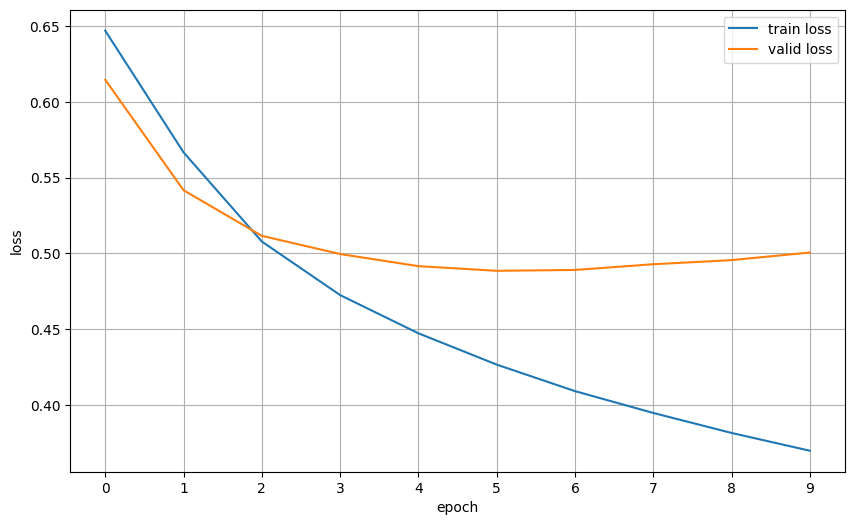

In [88]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")

ax.set_xlabel("epoch")
ax.set_ylabel("loss")

ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

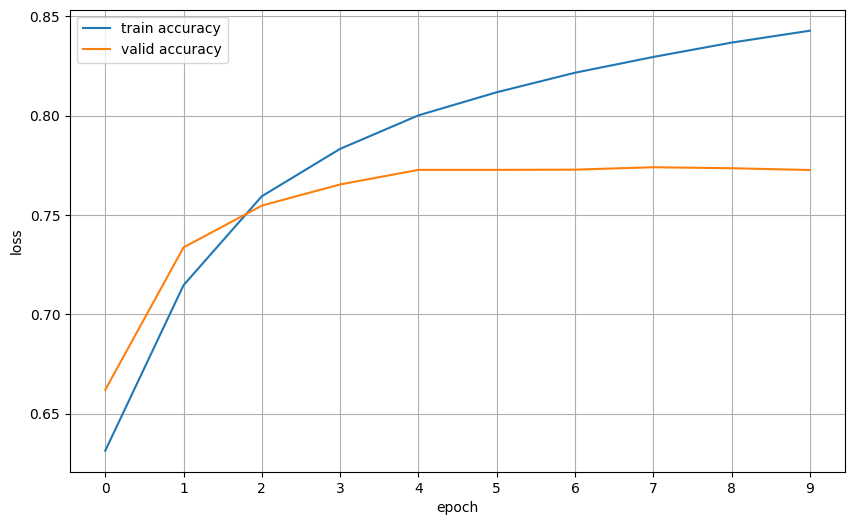

In [89]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [90]:
model.load_state_dict(torch.load("nbow.pt"))

test_loss, test_acc = evaluate(test_data_loader, model, criterion)

evaluating...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 54.10it/s]


In [92]:
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

test_loss: 0.493, test_acc: 0.774


In [97]:
def predict_sentiment(text, model, tokenizer, vocab):
    tokens = tokenizer(text)
    ids = vocab.lookup_indices(tokens)
    tensor = torch.LongTensor(ids).unsqueeze(dim=0)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [104]:
text = "good"

predict_sentiment(text, model, tokenizer, vocab)

(1, 1.0)

In [105]:
text = "bad"

predict_sentiment(text, model, tokenizer, vocab)

(0, 1.0)

In [106]:
text = "this book is great"

predict_sentiment(text, model, tokenizer, vocab)

(1, 1.0)

In [107]:
text = "this book is horrible"

predict_sentiment(text, model, tokenizer, vocab)

(0, 0.9954849481582642)